# corpus processing

In [1]:
!ls ../wiki_corpus/wiki_chs

AA AB AC AD AE AF AG AH AI AJ AK AL AM


## 1. Use BFS make all corpus a list

In [2]:
import os
corpus_path = '../wiki_corpus/wiki_chs'
corpus_list = []
need_visit = [corpus_path]
while need_visit:
    path = need_visit.pop(0)
    if os.path.isdir(path):
        need_visit += [path + '/' + p for p in os.listdir(path)]
    elif '.DS_Store' not in path:
        corpus_list.append(path)

print('first 10:', corpus_list[:10])
print('\ntotal corpus:', len(corpus_list))

first 10: ['../wiki_corpus/wiki_chs/AA/wiki_00', '../wiki_corpus/wiki_chs/AA/wiki_01', '../wiki_corpus/wiki_chs/AA/wiki_02', '../wiki_corpus/wiki_chs/AA/wiki_03', '../wiki_corpus/wiki_chs/AA/wiki_04', '../wiki_corpus/wiki_chs/AA/wiki_05', '../wiki_corpus/wiki_chs/AA/wiki_06', '../wiki_corpus/wiki_chs/AA/wiki_07', '../wiki_corpus/wiki_chs/AA/wiki_08', '../wiki_corpus/wiki_chs/AA/wiki_09']

total corpus: 1230


## 2. Count n-gram for single file

In [3]:
import re
import jieba
from collections import Counter
from functools import partial, reduce

def tokenize_string(string):
    clauses = [jieba.cut(c) for c in re.findall('[\w|\d]+', string)]
    tokens = [w for c in clauses for w in list(c)]
    return tokens
    
def count_ngram(string, n):
    tokens = tokenize_string(string)
    ngrams = [tuple(tokens[i-n:i]) for i in range(len(tokens)) if i > n]
    return Counter(ngrams)


def process_file(input_file, process_func):
    with open(input_file, 'r') as f:
        return process_func(f.read())
    
## test case
input_file = corpus_list[0]
word_count = process_file(input_file, process_func=partial(count_ngram, n=2))
word_count.most_common(20)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/x8/vryxg4fn2hd0zpk8t5xd0djm0000gn/T/jieba.cache
Loading model cost 0.751 seconds.
Prefix dict has been built succesfully.


[(('的', '研究'), 174),
 (('中', '的'), 129),
 (('上', '的'), 117),
 (('不同', '的'), 109),
 (('的', '是'), 93),
 (('的', '发展'), 87),
 (('的', '理论'), 81),
 (('都', '是'), 81),
 (('也', '是'), 78),
 (('是', '一个'), 77),
 (('10', '月'), 75),
 (('之间', '的'), 74),
 (('的', '影响'), 74),
 (('研究', '的'), 73),
 (('重要', '的'), 73),
 (('则', '是'), 71),
 (('年', '的'), 70),
 (('11', '月'), 68),
 (('zh', 'wikipedia'), 66),
 (('wikipedia', 'org'), 66)]

## 3. Multicore map reduce
first allow multiprocessing process a batch of data

In [4]:
import time
import multiprocessing
def multiprocess_count_ngram(batch_file, N):
    pool = multiprocessing.Pool()
    target_func = partial(process_file, process_func=partial(count_ngram, n=N))
    ngram_counts = pool.map(target_func, batch_file)
    pool.close()
    pool.join()
    return reduce(lambda x, y : x + y, ngram_counts)

# # test case
# tic = time.time()
# word_count = multiprocess_count_ngram(corpus_list[10], 1)
# print('total time:',time.time()-tic)

cut the overall computational tasks into pieces, and aggrigate the results, which lead to the result from the whole wiki zh corpus.

In [5]:
from tqdm import tqdm

def cut_list(data, batch_size):
    return [data[x:x+batch_size] for x in range(0, len(data), batch_size)]

def wikichs_count_ngram(N, batch_size=16):
    word_count = Counter([])
    corpus_chuncks = cut_list(corpus_list, 16)

    for chunck in tqdm(corpus_chuncks):
        word_count += multiprocess_count_ngram(chunck, N)
    return word_count

word_count = wikichs_count_ngram(1)

100%|██████████| 77/77 [20:29<00:00, 16.57s/it]


In [7]:
word_count.most_common(20)

[(('的',), 9885286),
 (('年',), 3009862),
 (('在',), 2816280),
 (('是',), 2209014),
 (('doc',), 2056551),
 (('为',), 1483796),
 (('和',), 1469596),
 (('月',), 1308439),
 (('了',), 1282062),
 (('zh',), 1103962),
 (('id',), 1035012),
 (('org',), 1031147),
 (('https',), 1030375),
 (('wiki',), 1029803),
 (('wikipedia',), 1029622),
 (('title',), 1029590),
 (('url',), 1029472),
 (('curid',), 1029447),
 (('与',), 941092),
 (('于',), 820759)]

total word count of corpus: 212721993
total vocabulary count: 3714045


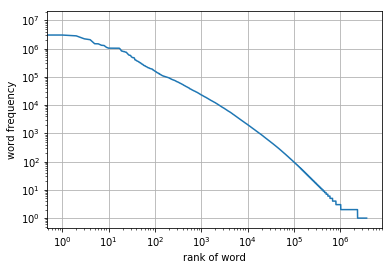

In [14]:
import matplotlib.pyplot as plt
freq = [f for gram, f in word_count.most_common()]
plt.loglog(freq)
plt.grid(True)
plt.xlabel('rank of word')
plt.ylabel('word frequency')
print('total word count of corpus:', sum(freq))
print('total vocabulary count:', len(freq))